In [1]:
import os
import time

import math
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFE

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
mpl.rcParams['figure.figsize'] = (20, 13)
mpl.rcParams['axes.grid'] = False

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 256)

from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# **Data Loading**

In [3]:
from dateutil.parser import parse

date_parser = lambda date: parse(date)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [ ]:
%cd MyDrive/dataset/SunSpot_Activity

In [4]:
df = pd.read_csv('Sunspots.csv',
                 usecols=['Date', 'Monthly Mean Total Sunspot Number'], 
                 parse_dates=['Date'],
                 date_parser=date_parser)
df.rename(columns={'Monthly Mean Total Sunspot Number': 'Monthly_Average_Sunspot'}, inplace=True)
df.head()

,Date,Monthly_Average_Sunspot
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


600 600


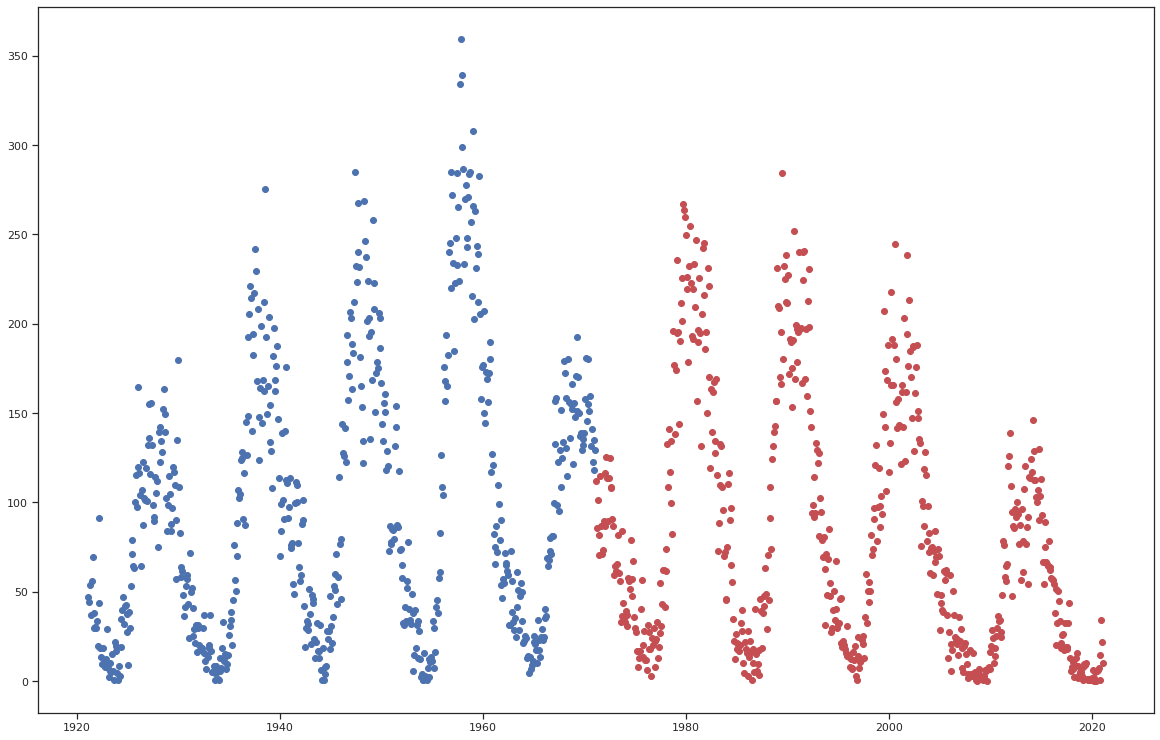

In [5]:
N_YEARS = 50
train_df = df[-2*N_YEARS*12:-N_YEARS*12]
test_df = df[-N_YEARS*12:]

train_size, test_size = len(train_df), len(test_df)
print(train_size, test_size)

compose_df = pd.concat([train_df, test_df])

plt.plot(train_df.Date, train_df.Monthly_Average_Sunspot, 'bo',
         test_df.Date, test_df.Monthly_Average_Sunspot, 'ro')

<AxesSubplot:xlabel='Date'>

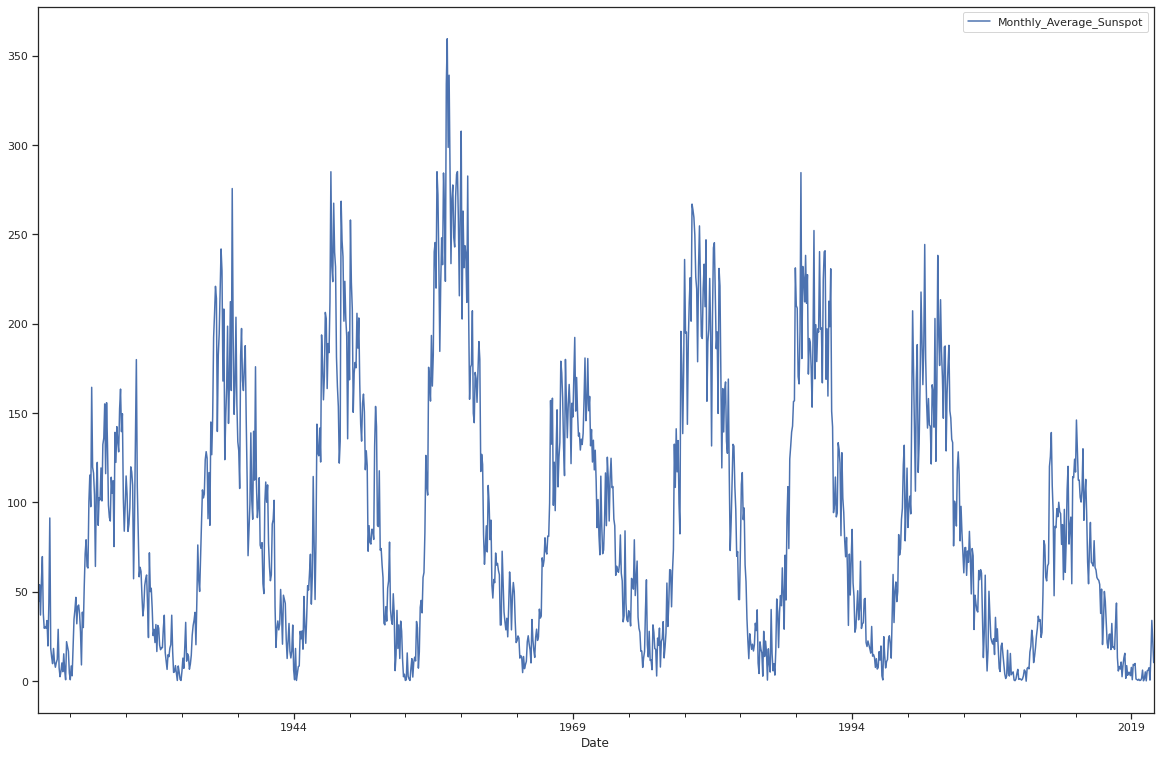

In [6]:
compose_df.set_index('Date').plot()

# **Modeling**

In [7]:
# Huber Loss, aka Smoothed Mean Absolute Error
import tensorflow as tf
from tensorflow.keras.losses import Huber, Reduction

loss_func = Huber(delta=1.0, 
                  reduction=tf.keras.losses.Reduction.NONE)

In [8]:
loss_df = pd.DataFrame()
loss_df['Date'] = test_df.Date

## **ARIMA**

In [9]:
%%time
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_set = train_df.copy()
train_set.set_index(keys='Date', drop=True, inplace=True)
train_set.index = pd.DatetimeIndex(data=train_set.index.values,
                                   freq=train_set.index.inferred_freq)
print('Frequency by:', train_set.index.inferred_freq)

# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
model = SARIMAX(endog=train_set['Monthly_Average_Sunspot'], 
                exog=None, 
                order=(1, 0, 2), # p,d,q - number of AR parameters, differences, and MA parameters
                seasonal_order=(1, 0, 2, 12*11), # P,D,Q,s - AR parameters, differences, MA parameters, and periodicity
                seasonal_periods=2,
                trend='ct', # c: const - t: time
                enforce_invertibility=False, 
                enforce_stationarity=True)

# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html#statsmodels.tsa.statespace.sarimax.SARIMAX.fit
ARIMA = model.fit(maxiter=50, 
                  optim_score='approx',
                  cov_type='approx', 
                  method='bfgs',
                  disp=True)

Frequency by: M


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


         Current function value: 4.658858
         Iterations: 50
         Function evaluations: 56
         Gradient evaluations: 56


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CPU times: user 2h 52min 42s, sys: 41min 45s, total: 3h 34min 28s
Wall time: 54min 50s


In [10]:
forecast = ARIMA.predict(start=train_size, 
                         end=train_size+test_size-1)
forecast = pd.DataFrame(forecast.values, index=test_df.index, columns=['Prediction'])
# display(forecast.head())
# display(forecast.tail())

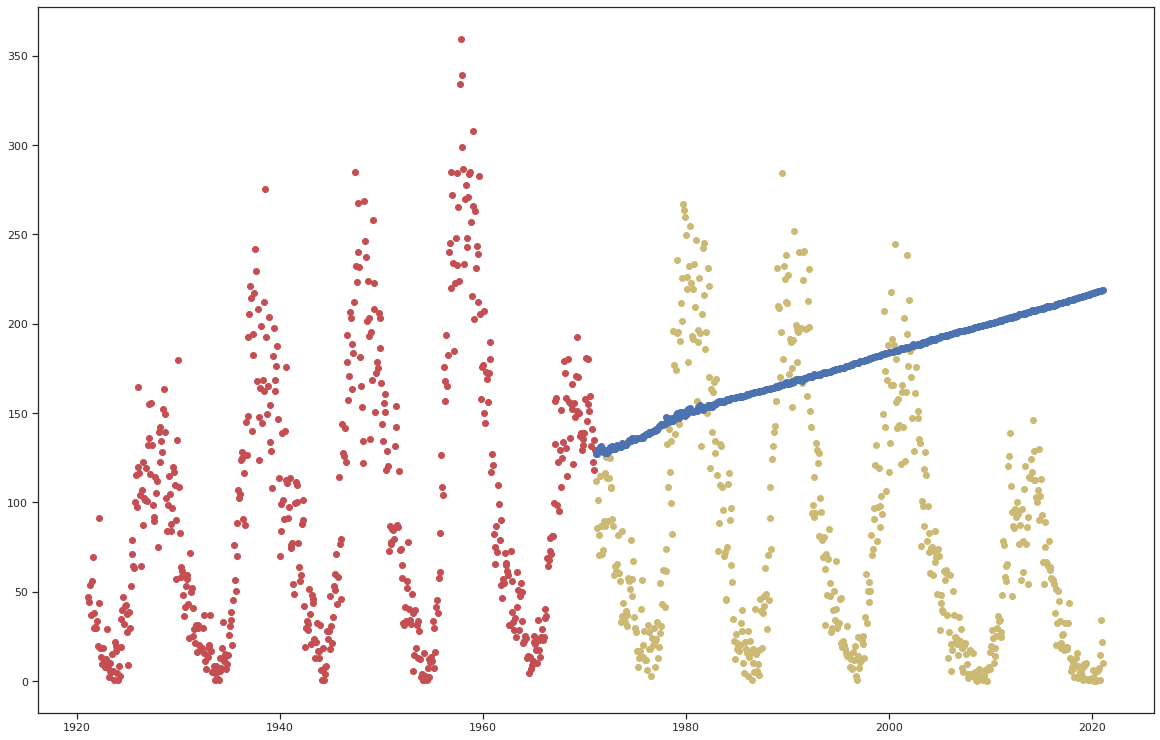

In [11]:
forecast['Date'] = test_df.Date
plt.plot(train_df.Date, train_df.Monthly_Average_Sunspot, 'ro',
         test_df.Date, test_df.Monthly_Average_Sunspot, 'yo', 
         forecast.Date, forecast.Prediction, 'bo')

In [12]:
loss = loss_func(test_df.Monthly_Average_Sunspot.values.reshape(-1,1),
                 forecast.Prediction.values.reshape(-1,1)).numpy()
loss_df['SARIMA'] = loss
loss_df['SARIMA'].describe()

count    600.000000
mean     107.630341
std       60.418274
min        0.090905
25%       58.615067
50%      110.708992
75%      155.091606
max      217.189682
Name: SARIMA, dtype: float64